# 0. McNulty Exploration

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

from sqlalchemy import create_engine
import os

from datetime import datetime, timedelta, date

In [1]:
os.environ['mdbUN']

NameError: name 'os' is not defined

In [2]:
engine_name = ('postgresql://' + 
               str(os.environ['psqlUN']) + ':' + 
               str(os.environ['psqlPW']) + 
               '@52.14.0.197:5432/detroit')
cnx = create_engine(engine_name)

The table of DLBA closed auctions currently lives on the AWS instance as a SQL table. It's fairly small, and I want to take a closer look and see what it takes to clean it up here. 

In [3]:
auctions_raw = pd.read_sql_query('''SELECT * FROM auctionsclosed''', cnx)

In [4]:
auctions_raw.shape

(1355, 13)

#### Pulling out a Test Set

On the first pass of tts, it throws an error when trying to use stratify, likely because of missing values in target column...

In [12]:
auctions_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355 entries, 0 to 1354
Data columns (total 13 columns):
address            1355 non-null object
parcelid           1355 non-null object
price              1355 non-null object
closingdate        1355 non-null object
salestatus         1355 non-null object
buyerstatus        1355 non-null object
purchasertype      1304 non-null object
program            1355 non-null object
councildistrict    1355 non-null int64
neighborhood       1355 non-null object
latitude           1355 non-null float64
longitude          1355 non-null float64
location           1355 non-null object
dtypes: float64(2), int64(1), object(10)
memory usage: 137.7+ KB


Since target values are needed in order to train or test, and this is the only column with any missing values, I'll drop any records without them. 

In [13]:
auctions_raw = auctions_raw.dropna()

auctions_raw.shape

(1304, 13)

In [14]:
auctions_raw, auctions_raw_test = train_test_split(auctions_raw, 
                                                   test_size=0.2, 
                                                   random_state=23, 
                                                   stratify=auctions_raw.purchasertype
                                                  )

In [15]:
print(auctions_raw_test.shape)
print(auctions_raw.shape)

(261, 13)
(1043, 13)


## Preliminary Exploration, Preparation for Cleaning

In [16]:
auctions_raw.sample(10)

,address,parcelid,price,closingdate,salestatus,buyerstatus,purchasertype,program,councildistrict,neighborhood,latitude,longitude,location
356,17184 Warrington,02003966.,"$9,900.00",2014-10-17,Closed,Selected,Homebuyer,Auction,2,University District,42.418444,-83.139582,"location\n(42.418444, -83.139582)"
234,5249 Cadieux,21075285.,"$4,000.00",2014-10-29,Closed,Selected,Investor,Auction,4,East English Village,42.408295,-82.931747,"location\n(42.408295, -82.931747)"
498,6891 Rutland,22069102.,"$2,600.00",2015-11-03,Closed,Selected,Homebuyer,Auction,7,Warren Ave Community,42.342530,-83.212534,"location\n(42.34253, -83.212534)"
118,6245 Stahelin,22084069.,"$7,700.00",2017-04-28,Closed,Selected,Homebuyer,Auction,7,Warrendale,42.335424,-83.224351,"location\n(42.335424, -83.224351)"
1260,545 Philip,21060801.,"$4,640.00",2017-04-13,Closed,Selected,Homebuyer,Auction,4,Jefferson Chalmers,42.368420,-82.939101,"location\n(42.36842, -82.939101)"
1096,10764 Wayburn,21063591.,"$5,100.00",2016-09-06,Closed,Selected,Homebuyer,Auction,4,Outer Drive-Hayes,42.417147,-82.955700,"location\n(42.417147, -82.9557)"
1106,9281 Boleyn,21074777.,"$4,000.00",2017-10-05,Closed,Selected,Homebuyer,Auction,4,Yorkshire Woods,42.417615,-82.941462,"location\n(42.417615, -82.941462)"
604,10973 Roxbury,21058991.,"$3,000.00",2015-08-07,Closed,Selected,Investor,Auction,4,Yorkshire Woods,42.419736,-82.950998,"location\n(42.419736, -82.950998)"
565,7667 Fielding,22103486.,"$3,500.00",2016-08-17,Closed,Selected,Homebuyer,Auction,7,Warrendale,42.347737,-83.240698,"location\n(42.347737, -83.240698)"
1012,5647 Caniff,13005450.,"$1,000.00",2015-10-28,Closed,Selected,Homebuyer,Auction,3,Buffalo Charles,42.405676,-83.044809,"location\n(42.405676, -83.044809)"


#### Purchaser Type

In [17]:
auctions_raw.purchasertype.value_counts()

Homebuyer    722
Investor     321
Name: purchasertype, dtype: int64

My target here is **purchasertype** (predict Homebuyer or Investor).

Though 722 to 321 (~2.25) is not the best-balanced ratio one could hope for, I had feared it would be much worse.

In [20]:
auctions_raw = auctions_raw.dropna()

auctions_raw.shape

(1043, 13)

In [25]:
buyer_counts = []
for buyer in auctions_raw.purchasertype.unique():
    buyer_counts.append(auctions_raw[auctions_raw.purchasertype == buyer].shape[0])

print("Homebuyers:", buyer_counts[0]/auctions_raw.shape[0])
print("Investors:", buyer_counts[1]/auctions_raw.shape[0])

Homebuyers: 0.6922339405560882
Investors: 0.3077660594439118


#### Parcel ID

In [26]:
auctions_raw.parcelid.value_counts().sort_values(ascending=False).head()

22056819.    1
22060866.    1
21054771.    1
22120385.    1
21059059.    1
Name: parcelid, dtype: int64

In [27]:
auctions_raw.parcelid.value_counts().sort_values().head()

22113676.    1
21077820.    1
08005628.    1
22089060.    1
13024044.    1
Name: parcelid, dtype: int64

Fortunately, all **Parcel IDs** are unique.

#### Price

In [28]:
trans = str.maketrans('','',',$')
auctions_raw.price = auctions_raw.price.apply(lambda p: p.translate(trans))

auctions_raw.price = auctions_raw.price.apply(lambda p: float(p))

In [29]:
auctions_raw[auctions_raw.price % 1 != 0]

,address,parcelid,price,closingdate,salestatus,buyerstatus,purchasertype,program,councildistrict,neighborhood,latitude,longitude,location


Since none of the values are fractional dollar amounts, we can turn them into `int` instead. And even if they did, 0.50 hardly matters when prices range in the thousands.

In [30]:
auctions_raw.price = auctions_raw.price.apply(lambda p: int(p))

In [31]:
auctions_raw.price.head()

243      7700
819     11400
1068     1000
674     62800
1339     1100
Name: price, dtype: int64

In [32]:
auctions_raw.describe()

,price,councildistrict,latitude,longitude
count,1043.000000,1043.000000,1043.000000,1043.000000
mean,6117.123682,4.158198,42.388308,-83.110507
std,9170.708252,2.126268,0.036585,0.111599
min,0.000000,1.000000,42.261900,-83.285664
25%,1000.000000,2.000000,42.357893,-83.209071
50%,3100.000000,4.000000,42.398671,-83.143340
75%,7400.000000,6.000000,42.416576,-83.001526
max,97900.000000,7.000000,42.449508,-82.916653


#### Date

In [39]:
auctions_raw.closingdate.iloc[0]

datetime.date(2014, 12, 19)

This is already a datetime object, so I can leave it as such.

In [40]:
print("Min date:", auctions_raw.closingdate.min())
print("Max date:", auctions_raw.closingdate.max())

Min date: 2014-06-12
Max date: 2017-10-12


#### Sale Status, Buyer Status, Program

In [41]:
auctions_raw.salestatus.value_counts()

Closed    1043
Name: salestatus, dtype: int64

In [42]:
auctions_raw.buyerstatus.value_counts()

Selected    1043
Name: buyerstatus, dtype: int64

In [43]:
auctions_raw.program.value_counts()

Auction    1043
Name: program, dtype: int64

These contain no relevant information, so all can be dropped.

In [44]:
# del auctions_raw['salestatus']
# del auctions_raw['buyerstatus']
# del auctions_raw['program']

auctions_raw = auctions_raw.drop(['salestatus','buyerstatus','program'], axis=1)

In [45]:
auctions_raw.head()

,address,parcelid,price,closingdate,purchasertype,councildistrict,neighborhood,latitude,longitude,location
243,6784 Asbury Park,22060958-9,7700,2014-12-19,Homebuyer,7,Warren Ave Community,42.341163,-83.205641,"location\n(42.341163, -83.205641)"
819,14345 Grandville,22088763.,11400,2015-04-23,Investor,1,Westwood Park,42.391877,-83.231375,"location\n(42.391877, -83.231375)"
1068,6754 Iowa,15004080-1,1000,2017-01-05,Homebuyer,3,Grant,42.424756,-83.032456,"location\n(42.424756, -83.032456)"
674,2224 W Boston Blvd,10002831.,62800,2015-06-17,Investor,5,Boston Edison,42.380017,-83.106803,"location\n(42.380017, -83.106803)"
1339,17650 Beland,17015265.,1100,2017-04-28,Homebuyer,3,Mount Olivet,42.424499,-83.008787,"location\n(42.424499, -83.008787)"


#### Council District

In [46]:
auctions_raw.councildistrict.value_counts()

7    257
4    228
1    159
2    134
5    106
3     95
6     64
Name: councildistrict, dtype: int64

Seven districts represented.

#### Neighborhood

In [47]:
unique_neighborhoods = auctions_raw.neighborhood.sort_values().unique()
print(unique_neighborhoods)
print(len(unique_neighborhoods))

['Arden Park' 'Aviation Sub' 'Bagley' 'Barton-McFarland' 'Belmont'
 'Berg-Lahser' 'Bethune Community' 'Blackstone Park' 'Boston Edison'
 'Boynton' 'Brightmoor' 'Buffalo Charles' 'Butler' 'Campau/Banglatown'
 'Castle Rouge' 'Central Southwest' 'Chadsey Condon' 'Chandler Park'
 'Chandler Park-Chalmers' 'Claytown' 'College Park' 'Conant Gardens'
 'Cornerstone Village' 'Crary/St Marys' 'Denby' 'Dexter-Linwood'
 'East English Village' 'East Village' 'Eden Gardens'
 'Evergreen Lahser 7/8' 'Evergreen-Outer Drive' 'Far West Detroit'
 'Farwell' 'Fiskhorn' 'Fitzgerald/Marygrove' 'Five Points' 'Franklin Park'
 'Garden Homes' 'Gateway Community' 'Grand River-St Marys' 'Grandmont'
 'Grandmont #1' 'Grant' 'Greenfield-Grand River' 'Greenwich' 'Henry Ford'
 'Herman Kiefer' 'Historic Atkinson' 'Holcomb Community' 'Hubbard Farms'
 'Hubbell-Lyndon' 'Hubbell-Puritan' 'Islandview' 'Jefferson Chalmers'
 'Joseph Berry Sub' 'Joy-Schaefer' 'LaSalle College Park' 'LaSalle Gardens'
 'Mapleridge' 'Martin Park' 'M

Initial reaction: that's a lot of neighborhoods. That said, there are no obvious instances of duplication, or typos where a dash was used in one case and a slash in the other, etc.

In [48]:
neighborhood_counts = auctions_raw.neighborhood.value_counts()

def print_counts(n, compare='atleast'):
    if compare == 'atleast':
        hood_counts = neighborhood_counts[neighborhood_counts >= n]
        print(f"At least {n}: {hood_counts.shape[0]} neighborhoods, {hood_counts.sum()} records", )
    elif compare == 'less':
        hood_counts = neighborhood_counts[neighborhood_counts < n]
        print(f"Less than {n}: {hood_counts.shape[0]} neighborhoods, {hood_counts.sum()} records", )
    elif compare == 'equals':
        hood_counts = neighborhood_counts[neighborhood_counts == n]
        print(f"Exactly {n}: {hood_counts.shape[0]} neighborhoods, {hood_counts.sum()} records", )

print_counts(1)
print_counts(1, compare='equals')
print_counts(5, compare='less')
print_counts(5)
print_counts(10)

At least 1: 110 neighborhoods, 1043 records
Exactly 1: 26 neighborhoods, 26 records
Less than 5: 59 neighborhoods, 121 records
At least 5: 51 neighborhoods, 922 records
At least 10: 34 neighborhoods, 802 records


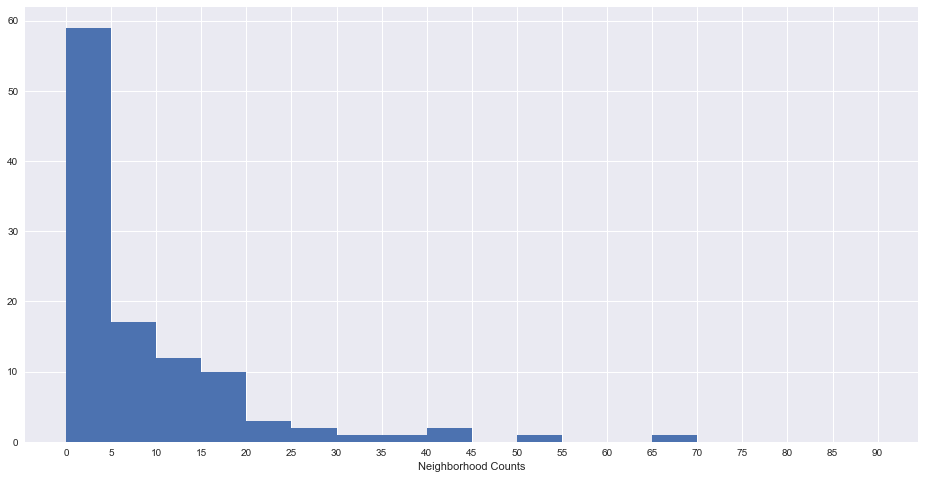

In [49]:
plt.figure(figsize=(16,8))
plt.hist(neighborhood_counts, bins=18, range=[0,90]);
plt.xticks([n*5 for n in range(19)])
plt.xlabel("Neighborhood Counts");

About half of the 113 neighborhoods only occur fewer than 5 times each; only 34 occur 10 times or more. 113 columns make for a lot of dummy variables, if I'm going to use this as a predictor. Wondering if I should replace any neighborhood name occuring less than five times with 'Other,' or only use the X most popular as predictors.

In [50]:
for hood in neighborhood_counts[neighborhood_counts <= 5].index.sort_values():
    print(hood)

Arden Park
Belmont
Berg-Lahser
Bethune Community
Blackstone Park
Brightmoor
Butler
Castle Rouge
Chandler Park
Chandler Park-Chalmers
East Village
Eden Gardens
Evergreen Lahser 7/8
Far West Detroit
Five Points
Garden Homes
Gateway Community
Grand River-St Marys
Grandmont
Grandmont #1
Grant
Greenwich
Henry Ford
Herman Kiefer
Holcomb Community
Hubbard Farms
Hubbell-Lyndon
Hubbell-Puritan
Joseph Berry Sub
Joy-Schaefer
LaSalle College Park
LaSalle Gardens
Mapleridge
McNichols Evergreen
Mexicantown
Minock Park
Nolan
North Corktown
Oak Grove
Oakman Blvd Community
Old Redford
Pershing
Pilgrim Village
Plymouth-Hubbell
Pulaski
Riverdale
Rosedale Park
San Bernardo
Seven Mile Lodge
Seven Mile-Rouge
Sherwood
South of Six
Southfield Plymouth
University District
Von Steuben
We Care Community
West Outer Drive
West Village
West Virginia Park
Westwood Park
Woodbridge


In [51]:
n_counts_df = neighborhood_counts.reset_index().rename(columns={'index': 'neighborhood', 'neighborhood': 'n_count'})

auctions_raw = auctions_raw.merge(n_counts_df, on='neighborhood')

In [52]:
auctions_raw[auctions_raw.n_count < 10].purchasertype.value_counts()

Homebuyer    160
Investor      81
Name: purchasertype, dtype: int64

In [53]:
auctions_raw[auctions_raw.n_count < 5].purchasertype.value_counts()

Homebuyer    83
Investor     38
Name: purchasertype, dtype: int64

The ratios of Homebuyers to Investors with the neighborhoods that occur less than 10 and less than 5 times are not that far off from the ratio of the overall set. Seems like it wouldn't make too much sense to treat them as "other." Let's see if there's any indication that neighborhoods have any great amount of predictive power, and might be able to be binned in one way or another...

In [54]:
def nhood_investor_ratios(df, nhood_df):
    """
    Calculates the ratio of investors to all buyers per neighborhood, appends as 
    a new column to neighborhoods dataframe.
    ---
    IN
    df: main auction dataframe
    nhood_df: dataframe of neighborhoods and frequencies
    OUT
    nhood_df: updated with investor ratio column
    """

    inv_ratios = []
    for _, row in nhood_df.iterrows():
        nhood = row['neighborhood']
        temp = df[df.neighborhood == nhood]
        inv_ratio = temp[temp.purchasertype == 'Investor'].shape[0] / temp.shape[0]
        inv_ratios.append(inv_ratio)
    nhood_df['inv_ratio'] = inv_ratios
    
    return nhood_df
        
n_counts_df = nhood_investor_ratios(auctions_raw, n_counts_df)

In [55]:
def rand_investor_ratios(df, max_size=100, samples=200):
    """
    Calculates investors/total buyers ratio for a given number of random samples ranging in size
    from 1 to the given maximum.
    ---
    IN
    df: auctions dataframe
    max_size: maximum sample size (int)
    samples: number of samples (int)
    OUT
    sample_sizes: list of sample sizes (list of ints)
    investor_ratios: list of corresponding investor ratios (list of ints)
    (both in a tuple)
    """
    
    sample_sizes = []
    inv_ratios = []
    
    for i in range(samples):
        size = np.random.randint(1,max_size+1)
        temp = df.sample(size)
        inv_ratio = temp[temp.purchasertype == 'Investor'].shape[0] / temp.shape[0]
        sample_sizes.append(size)
        inv_ratios.append(inv_ratio)

    return sample_sizes, inv_ratios

In [56]:
def rand_investor_ratios2(df, samples=200):
    """
    Same as above, but uses geometric distribution to generate sample sizes.
    ---
    IN
    df: auctions dataframe
    max_size: maximum sample size (int)
    samples: number of samples (int)
    OUT
    sample_sizes: list of sample sizes (list of ints)
    investor_ratios: list of corresponding investor ratios (list of ints)
    (both in a tuple)
    """
    
    #sample_sizes = np.random.geometric(p=0.05, size=samples)
    sample_floats = np.random.gamma(0.4,20,113)
    sample_sizes = [int(i)+1 for i in sample_floats]
    inv_ratios = []
    
    for size in sample_sizes:
        temp = df.sample(size)
        inv_ratio = temp[temp.purchasertype == 'Investor'].shape[0] / temp.shape[0]
        inv_ratios.append(inv_ratio)

    return sample_sizes, inv_ratios

In [57]:
pop_inv_ratio = auctions_raw.purchasertype.value_counts()[1] / auctions_raw.shape[0]

''

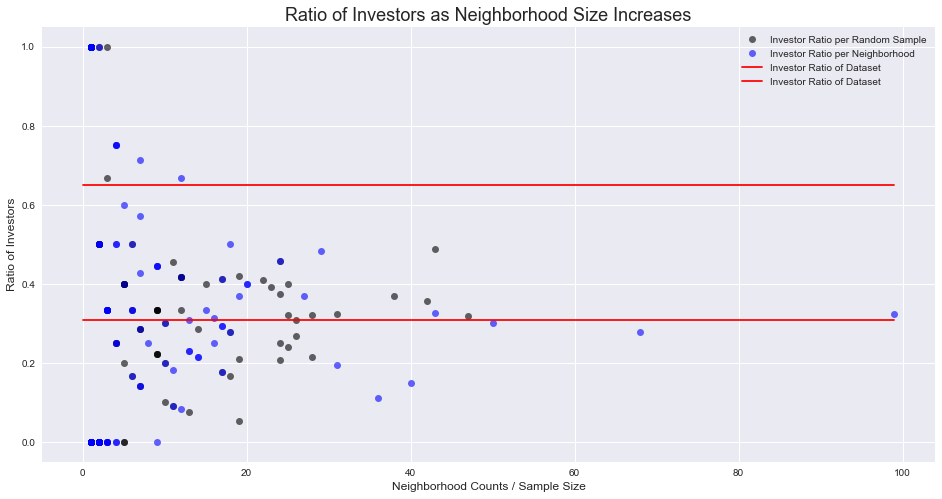

In [58]:
pir = pop_inv_ratio

x = n_counts_df.n_count
y = n_counts_df.inv_ratio

x_rand, y_rand = rand_investor_ratios2(auctions_raw, samples=100)

x2 = np.linspace(0,max(max(x_rand),max(x)),100)
y2 = [pir] * len(x2)
y3 = [0.65] * len(x2)

# n = np.e ** (x2/40)
# y3 = (1-pir) / n + pir
# y4 = pir - pir / n

plt.figure(figsize=(16,8))
plt.plot(x_rand, y_rand, 'ko', alpha=0.6, label="Investor Ratio per Random Sample")
plt.plot(x, y, 'bo', alpha=0.6, label="Investor Ratio per Neighborhood")
plt.plot(x2, y2, 'r-', label='Investor Ratio of Dataset')
plt.plot(x2, y3, 'r-', label='Investor Ratio of Dataset')
# plt.plot(x2, y3, 'r--')
# plt.plot(x2, y4, 'r--')
plt.legend()
plt.xlabel("Neighborhood Counts / Sample Size", fontsize=12)
plt.ylabel("Ratio of Investors", fontsize=12)
plt.title("Ratio of Investors as Neighborhood Size Increases", fontsize=18)
;

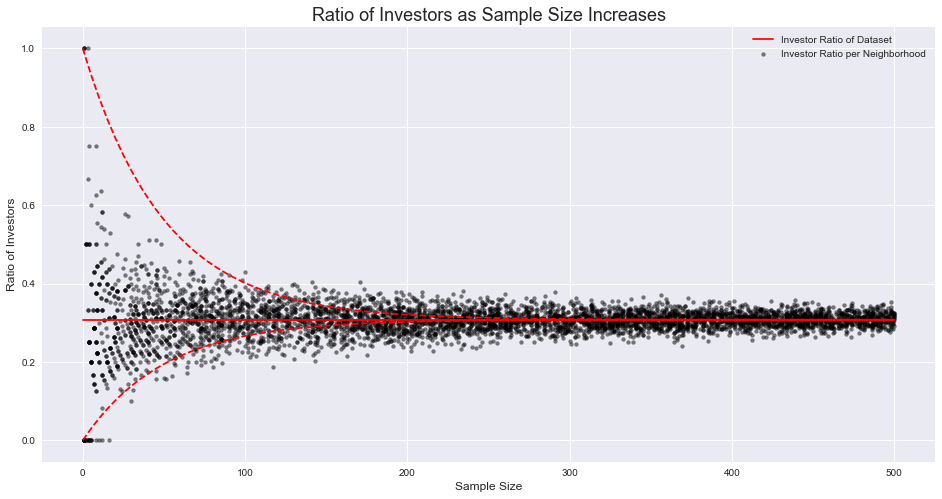

In [59]:
pir = pop_inv_ratio

max_x = 500

x, y = rand_investor_ratios(auctions_raw, max_size=max_x, samples=5000)

x2 = np.linspace(0,max_x,100)
y2 = [pir] * len(x2)

n = np.e ** (x2/50)
y3 = (1-pir) / n + pir
y4 = pir - pir / n

plt.figure(figsize=(16,8))
plt.scatter(x, y, color='black', alpha=0.5, s=15, label='Investor Ratio per Neighborhood')
plt.plot(x2, y2, 'r-', label='Investor Ratio of Dataset')
plt.plot(x2, y3, 'r--')
plt.plot(x2, y4, 'r--')
plt.legend()
plt.xlabel("Sample Size", fontsize=12)
plt.ylabel("Ratio of Investors", fontsize=12)
plt.title("Ratio of Investors as Sample Size Increases", fontsize=18);

''

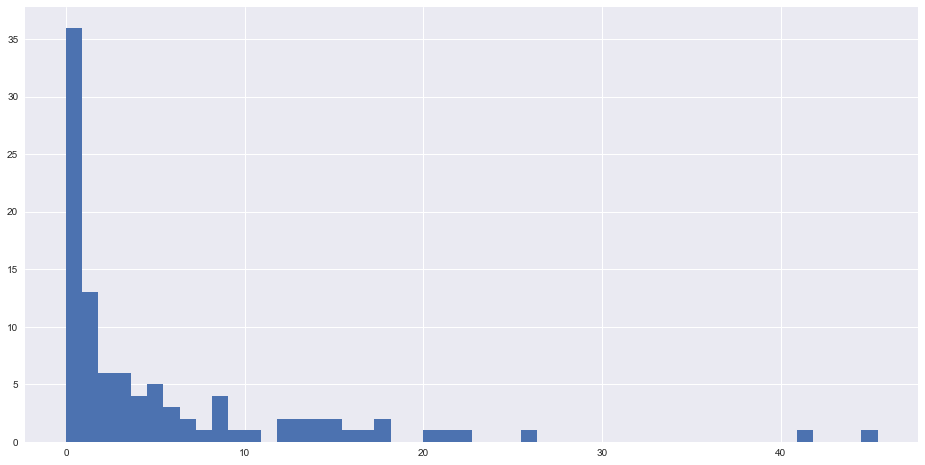

In [60]:
plt.figure(figsize=(16,8))
#plt.hist(np.random.geometric(p=0.04, size=100), bins=50)
#plt.hist(np.random.chisquare(2,100), bins=50)
#plt.hist(np.random.logistic(1,100,100), bins=50)
plt.hist(np.random.gamma(0.4,20,100), bins=50)
;

### Visualizations

In [61]:
inv_lats = list(auctions_raw[auctions_raw.purchasertype == 'Investor']['latitude'])
inv_lons = list(auctions_raw[auctions_raw.purchasertype == 'Investor']['longitude'])
hb_lats = list(auctions_raw[auctions_raw.purchasertype == 'Homebuyer']['latitude'])
hb_lons = list(auctions_raw[auctions_raw.purchasertype == 'Homebuyer']['longitude'])

''

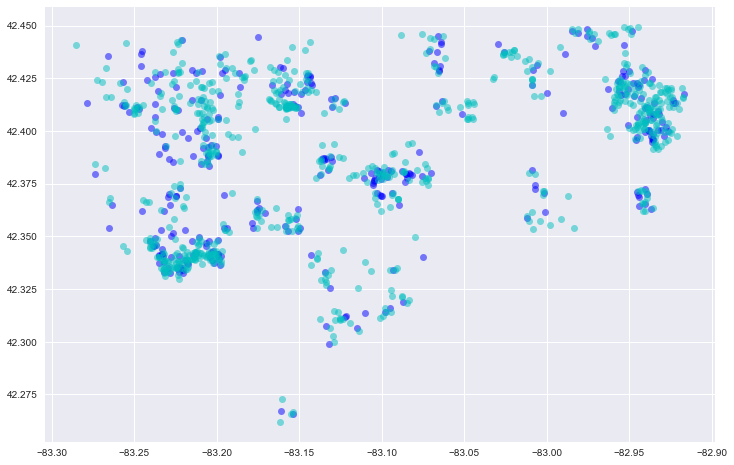

In [62]:
plt.figure(figsize=(12,8))
plt.plot(inv_lons, inv_lats, 'bo', alpha=0.5)
plt.plot(hb_lons, hb_lats, 'co', alpha=0.5)
;

''

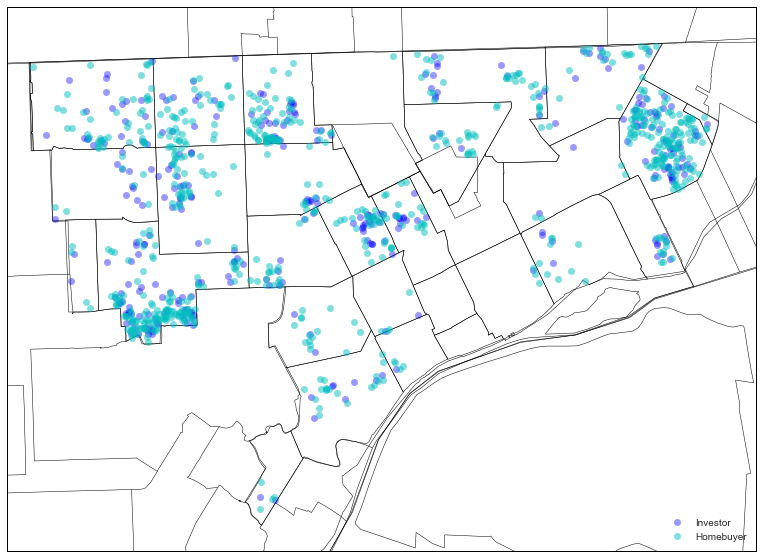

In [63]:
plt.figure(figsize=(16, 10))
m = Basemap(projection='merc', # 'merc', 'lcc'
            resolution='i', # 'c', 'l', 'i', 'h', 'f', None
            area_thresh=0.1,
            # width=36000,
            # height=24000,
            # lat_0=42.3313889, lon_0=-83.0458333,
            llcrnrlon=-83.30, llcrnrlat=42.245, 
            urcrnrlon=-82.89, urcrnrlat=42.465, 
           )

# m.etopo(scale=0.5, alpha=0.5)

# m.drawcountries()
# m.drawcoastlines()
# m.drawstates()
# m.drawcounties()
# m.fillcontinents(color='white', lake_color='aqua')
m.drawmapboundary(fill_color='white')
# m.drawrivers(color='blue')
# m.bluemarble(scale=0.2)

# m.readshapefile("../data/river/AOC_MI_DETROIT", 'river2')
# m.readshapefile("../data/tract10_mi/tract10_miv14a", 'cities') # needs reformatting
m.readshapefile("../data/mi_admin/michigan_administrative", 'admin')
# m.readshapefile("../data/neighborhoods/geo_export_333d2406-1960-4afa-a078-0ff790c78e70", 'neighborhoods')
m.readshapefile("../data/zipcodes/geo_export_681b42b5-2249-4750-9e61-6e2271a3974d", 'zips')
# m.readshapefile("../data/mi_coast/michigan_coastline", 'river')

xh, yh = m(hb_lons, hb_lats)
xi, yi = m(inv_lons, inv_lats)

plt.plot(xi, yi, 'bo', markersize=7, alpha=0.4, label="Investor")
plt.plot(xh, yh, 'co', markersize=7, alpha=0.5, label="Homebuyer")
plt.legend(loc='lower right')

;

In [23]:
auctions_raw[auctions_raw.neighborhood == 'Morningside']

,address,parcelid,price,closingdate,salestatus,buyerstatus,purchasertype,program,councildistrict,neighborhood,latitude,longitude,location
11,4716 Courville,21071462.,"$1,100.00",2017-09-29,Closed,Selected,Investor,Auction,4,Morningside,42.401024,-82.937461,"location\n(42.401024, -82.937461)"
12,5291 Courville,21071681.,"$1,100.00",2017-09-15,Closed,Selected,Homebuyer,Auction,4,Morningside,42.405489,-82.941161,"location\n(42.405489, -82.941161)"
74,5050 Somerset,21067106.,"$5,600.00",2016-07-26,Closed,Selected,Homebuyer,Auction,4,Morningside,42.400339,-82.947990,"location\n(42.400339, -82.94799)"
273,5090 Three Mile Dr,21071170.,"$1,300.00",2016-08-12,Closed,Selected,Homebuyer,Auction,4,Morningside,42.403723,-82.940490,"location\n(42.403723, -82.94049)"
274,5114 Three Mile Dr,21071173.,"$1,100.00",2016-09-07,Closed,Selected,Homebuyer,Auction,4,Morningside,42.404018,-82.940687,"location\n(42.404018, -82.940687)"
275,5785 Three Mile Dr,21071231.,"$4,100.00",2017-03-15,Closed,Selected,Homebuyer,Auction,4,Morningside,42.408412,-82.944293,"location\n(42.408412, -82.944293)"
276,5557 Three Mile Dr,21071242.,"$1,000.00",2016-06-21,Closed,Selected,Homebuyer,Auction,4,Morningside,42.406349,-82.942941,"location\n(42.406349, -82.942941)"
277,5239 Three Mile Dr,21071259.,"$4,100.00",2016-06-24,Closed,Selected,Homebuyer,Auction,4,Morningside,42.404538,-82.941762,"location\n(42.404538, -82.941762)"
294,3921 Courville,21071774.,"$1,800.00",2016-06-01,Closed,Selected,Homebuyer,Auction,4,Morningside,42.394720,-82.934091,"location\n(42.39472, -82.934091)"
295,5730 Audubon,21071919.,"$21,100.00",2014-08-15,Closed,Selected,Homebuyer,Auction,4,Morningside,42.408763,-82.941047,"location\n(42.408763, -82.941047)"


In [24]:
lat_in = auctions_raw.latitude[610]
lng_in = auctions_raw.longitude[610]

lat_lim = 0.015
lng_lim = 0.02

sub_df = auctions_raw[
    (auctions_raw.latitude > (lat_in - lat_lim)) &
    (auctions_raw.latitude < (lat_in + lat_lim)) &
    (auctions_raw.longitude > (lng_in - lng_lim)) &
    (auctions_raw.longitude < (lng_in + lng_lim))
    ]

inv_lats2 = list(sub_df[sub_df.purchasertype == 'Investor']['latitude'])
inv_lons2 = list(sub_df[sub_df.purchasertype == 'Investor']['longitude'])
hb_lats2 = list(sub_df[sub_df.purchasertype == 'Homebuyer']['latitude'])
hb_lons2 = list(sub_df[sub_df.purchasertype == 'Homebuyer']['longitude'])

''

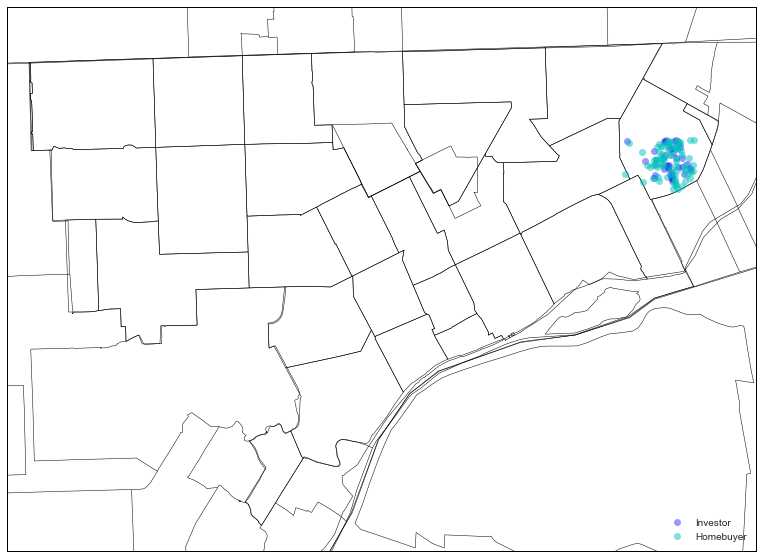

In [25]:
plt.figure(figsize=(16, 10))
m = Basemap(projection='merc', # 'merc', 'lcc'
            resolution='i', # 'c', 'l', 'i', 'h', 'f', None
            area_thresh=0.1,
            # width=36000,
            # height=24000,
            # lat_0=42.3313889, lon_0=-83.0458333,
            llcrnrlon=-83.30, llcrnrlat=42.245, 
            urcrnrlon=-82.89, urcrnrlat=42.465, 
           )

m.drawmapboundary(fill_color='white')
m.readshapefile("../data/mi_admin/michigan_administrative", 'admin')
m.readshapefile("../data/zipcodes/geo_export_681b42b5-2249-4750-9e61-6e2271a3974d", 'zips')

xh, yh = m(hb_lons2, hb_lats2)
xi, yi = m(inv_lons2, inv_lats2)

plt.plot(xi, yi, 'bo', markersize=7, alpha=0.4, label="Investor")
plt.plot(xh, yh, 'co', markersize=7, alpha=0.5, label="Homebuyer")
plt.legend(loc='lower right')

;